In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models



# 1. Data Preprocessing

## 1.1 Data Acquisition

In [8]:
file_path = 'KDDTest+.txt'

# Read the text file into a DataFrame without headers
train_df = pd.read_csv(file_path, header=None)

# Define the column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack', 'level'
]


# Assign the column names to the DataFrame
train_df.columns = columns

# Display the first few rows with headers
print(f"Inital shape: {train_df.shape}")
keep_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack'
]

# Drop columns not in the keep_columns list as we use packet tracing software
train_df = train_df[keep_columns]

# Convert 'attack' column to binary classification
# Assuming 'normal' means no attack and any other value is an anomaly
train_df['attack'] = train_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')    
train_df.drop_duplicates(inplace=True)
print(f"New shape: {train_df.shape}")
print(train_df.head())

Inital shape: (22544, 43)
New shape: (22475, 28)
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  count  ...  dst_host_count  dst_host_srv_count  \
0               0       0    229  ...             255                  10   
1               0       0    136  ...             255                   1   
2               0       0      1  ...             134                  86   
3               0       0      1  ...               3                  57   
4               0       0      1  ...              29                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate

## 1.2 Encoding, Scaling and PCA

In [9]:
# Review this encoding if there exists any better method

encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoder3 = LabelEncoder()

train_df['protocol_type'] = encoder1.fit_transform(train_df['protocol_type'])
train_df['service'] = encoder2.fit_transform(train_df['service'])
train_df['flag'] = encoder3.fit_transform(train_df['flag'])

X = train_df.drop(columns = ['attack'])
y = train_df['attack']

attack_encoder = LabelEncoder()
y = attack_encoder.fit_transform(y)

# Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)


In [10]:
# Fitting the scalers and pca on training data

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 
pca = PCA(n_components = 0.95, random_state = 42)
X_train_pca = pca.fit_transform(X_train_scaled)


# For validation data (Using the same scaler and pca):
X_val_scaled = scaler.transform(X_val)

X_val_pca = pca.transform(X_val_scaled)

In [11]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

## 1.3 Using the tf.data.Dataset API

In [12]:
# Reshaping X_train and X_val according to what tensorflow expects
X_train_reshaped = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1],1))
X_val_reshaped = X_val_pca.reshape((X_val_pca.shape[0], X_val_pca.shape[1],1))

# Converting into tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_reshaped, y_val))

# Using the batch size = 32 and batching
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_reshaped)).batch(batch_size)
val_dataset =val_dataset.shuffle(buffer_size=len(X_val_reshaped)).batch(batch_size)

# prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
X_train_reshaped.shape, X_val_reshaped.shape, y_train.shape, y_val.shape

((15732, 16, 1), (6743, 16, 1), (15732,), (6743,))

In [16]:
X_train_reshaped[0].shape

(16, 1)

# 2. Training

## 2.1 CNN model definition

In [17]:
i_shape = X_train_reshaped[0].shape

model = models.Sequential()

# First Conv layer
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=i_shape))

# Second Conv layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

# Third Conv layer
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))

# Fourth Conv layer
model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))

# Fifth Conv layer
model.add(layers.Conv1D(filters=512, kernel_size=3, activation='relu'))

# First MaxPool layer
model.add(layers.MaxPooling1D(pool_size=2))

# Second MaxPool layer
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output before Fully Connected layers
model.add(layers.Flatten())

# First Fully Connected (Dense) layer
model.add(layers.Dense(256, activation='relu'))

# Second Fully Connected (Dense) layer
model.add(layers.Dense(128, activation='relu'))

# Third Fully Connected (Dense) layer
model.add(layers.Dense(64, activation='relu'))

# Fourth Fully Connected (Dense) layer
model.add(layers.Dense(32, activation='relu'))
# Output layer with SoftMax for classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/home/mejan/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 14, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 6, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697,921 (2.66 MB)

 Trainable params: 697,921 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Train and save

In [18]:
epochs = 20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20


I0000 00:00:1726546522.415169    8946 service.cc:145] XLA service 0x7bc304012c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726546522.415198    8946 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-09-17 10:00:22.450824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-17 10:00:22.659467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1726546523.429652   10566 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1233', 4 bytes spill stores, 4 bytes spill loads



130/492 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7440 - loss: 0.4888

I0000 00:00:1726546525.874614    8946 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


488/492 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8418 - loss: 0.3361

I0000 00:00:1726546527.631245   10678 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1233', 4 bytes spill stores, 4 bytes spill loads



492/492 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8423 - loss: 0.3351 - val_accuracy: 0.9263 - val_loss: 0.1552
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9324 - loss: 0.1561 - val_accuracy: 0.9393 - val_loss: 0.1379
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9436 - loss: 0.1302 - val_accuracy: 0.9488 - val_loss: 0.1275
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9490 - loss: 0.1211 - val_accuracy: 0.9533 - val_loss: 0.1077
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9553 - loss: 0.0998 - val_accuracy: 0.9515 - val_loss: 0.1089
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9557 - loss: 0.1010 - val_accuracy: 0.9598 - val_loss: 0.1077
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9618 - loss: 0.0903 - val_accuracy: 0.9524 - val_loss: 0.1386
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9622 - loss: 0.0863 - val_accuracy: 0.9646 - va

In [19]:
model.save("third_cnn.keras")


## 2.3 Plotting

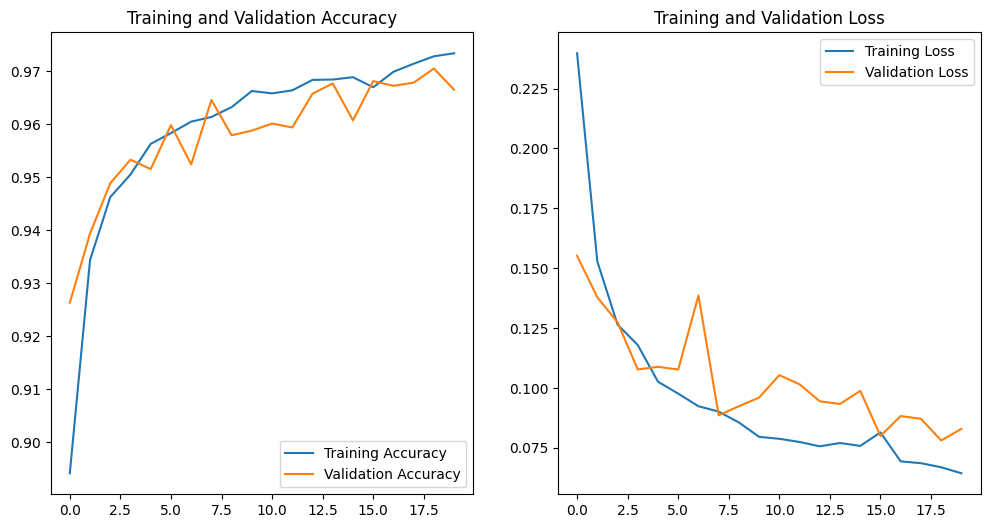

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('test.png')
plt.show()